In [6]:
!pip install pydotplus

You should consider upgrading via the 'pip install --upgrade pip' command.


In [7]:
!pip install graphviz

You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
#Initialise spark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [11]:
# get raw from github and create pyspark dataframe
from pyspark import SparkFiles
url="https://raw.githubusercontent.com/IPGreene/FW-Neural-net/master/ASA_log.csv"
spark.sparkContext.addFile(url)
data = spark.read.csv(SparkFiles.get("ASA_log.csv"), header=True)

In [5]:
# necessary imports except for keras that will be done within the appropriate cell
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, StandardScaler, OneHotEncoderEstimator
from pyspark.sql.functions import udf
from pyspark.sql.types import *
from pyspark.sql.functions import rand, countDistinct
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
import matplotlib.pyplot as plt

In [12]:
# Data exploration and discovery
# for now we will cast columns to an integer for visualization and inspect data
data.createOrReplaceTempView("firewall")
data = spark.sql('SELECT * FROM firewall')
data = data.withColumn('sourcePort', data['sourcePort'].cast(IntegerType()))
data = data.withColumn('destinationPort', data['destinationPort'].cast(IntegerType()))
data = data.withColumn('deviceId', data['deviceId'].cast(IntegerType()))
data = data.withColumn('event_category', data['event_category'].cast(IntegerType()))
data = data.withColumn('relevance', data['relevance'].cast(IntegerType()))
data = data.withColumn('credibility', data['credibility'].cast(IntegerType()))
data = data.withColumn('severity', data['severity'].cast(IntegerType()))
data = data.withColumn('magnitude', data['magnitude'].cast(IntegerType()))
data = data.fillna('Unknown')
data.show()

+----------+---------------+------------+-------------+--------+--------------+-------------------+--------------------+---------+-----------+--------+---------+--------------------+----------+
|sourcePort|destinationPort|protocolName|        IPgeo|deviceId|event_category|categoryDescription|    eventDescription|relevance|credibility|severity|magnitude|      Event_DateTime|eventCount|
+----------+---------------+------------+-------------+--------+--------------+-------------------+--------------------+---------+-----------+--------+---------+--------------------+----------+
|     52217|           2000|      tcp_ip|      Unknown|   31410|          5010|       Misc Exploit|Unrecognized Palo...|        8|         10|       9|        9|Mar 14, 2019, 8:2...|         1|
|     51405|             80|      tcp_ip|      Unknown|   31410|          7024|   Information Leak|A directory trave...|        8|         10|       1|        6|Mar 14, 2019, 8:2...|         1|
|     36002|            445|  

In [14]:
# manually inspect how many entries of each category exist
# need to remove columns where many categories have counts <3
column_names = data.columns
for c in column_names:
    data.groupby(c).count().show()

+----------+-----+
|sourcePort|count|
+----------+-----+
|     64121|    1|
|      9900|    1|
|     57380|    1|
|     64822|    1|
|     43256|    1|
|     51388|    1|
|     59086|    1|
|     49686|    1|
|     21058|    1|
|     57412|    1|
|     33118|    1|
|     59115|    1|
|     59832|    1|
|     50610|    1|
|     48308|    1|
|       137|   31|
|     59142|    1|
|     55607|    1|
|     59547|    1|
|     57783|    1|
+----------+-----+
only showing top 20 rows

+---------------+-----+
|destinationPort|count|
+---------------+-----+
|           3000|    1|
|            137|   39|
|          50610|    1|
|             53|  225|
|           5061|    1|
|           8612|   23|
|            593|    2|
|           8011|    1|
|          44777|    1|
|             81|    3|
|           6667|   10|
|          49154|    3|
|           4899|    1|
|           2323|    1|
|           8318|    6|
|             22|    5|
|          51219|    1|
|          33333|    3|
|           79

In [15]:
# Remove the appropraite columns
data = data.drop('sourcePort', 'destinationPort', 'Event_DateTime', 'categoryDescription', 'eventDescription', 'eventCount')

(array([ 68.,   0., 136.,   0.,   0., 126.,   0.,   0., 717.,   0.,   0.,
        389.,   0.,   0.,  49.,   0.,   0.,  14.,   0.,   1.]),
 array([2.  , 2.35, 2.7 , 3.05, 3.4 , 3.75, 4.1 , 4.45, 4.8 , 5.15, 5.5 ,
        5.85, 6.2 , 6.55, 6.9 , 7.25, 7.6 , 7.95, 8.3 , 8.65, 9.  ]),
 <a list of 20 Patch objects>)

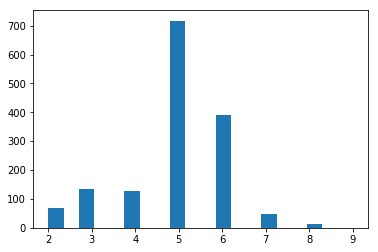

In [16]:
# make historgrams of columns on a scale
bins, counts = data.select('relevance').rdd.flatMap(lambda x: x).histogram(20)
plt.hist(bins[:-1], bins=bins, weights=counts)

(array([ 272.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0., 1228.]),
 array([ 5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,  6.75,  7.  ,
         7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,  9.  ,  9.25,
         9.5 ,  9.75, 10.  ]),
 <a list of 20 Patch objects>)

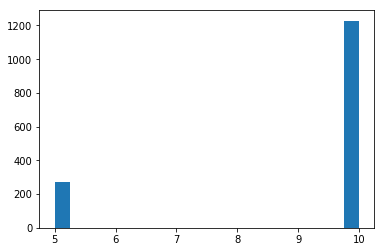

In [17]:
bins, counts = data.select('credibility').rdd.flatMap(lambda x: x).histogram(20)
plt.hist(bins[:-1], bins=bins, weights=counts)

(array([1.331e+03, 0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.600e+02, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 5.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([0.  , 0.45, 0.9 , 1.35, 1.8 , 2.25, 2.7 , 3.15, 3.6 , 4.05, 4.5 ,
        4.95, 5.4 , 5.85, 6.3 , 6.75, 7.2 , 7.65, 8.1 , 8.55, 9.  ]),
 <a list of 20 Patch objects>)

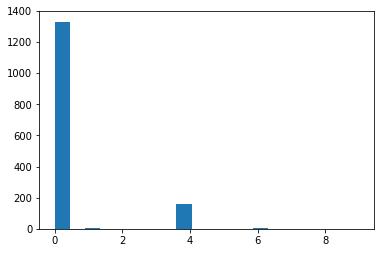

In [18]:
bins, counts = data.select('severity').rdd.flatMap(lambda x: x).histogram(20)
plt.hist(bins[:-1], bins=bins, weights=counts)

(array([ 68.,   0., 136.,   0.,   0., 126.,   0.,   0., 717.,   0.,   0.,
        389.,   0.,   0.,  49.,   0.,   0.,  14.,   0.,   1.]),
 array([2.  , 2.35, 2.7 , 3.05, 3.4 , 3.75, 4.1 , 4.45, 4.8 , 5.15, 5.5 ,
        5.85, 6.2 , 6.55, 6.9 , 7.25, 7.6 , 7.95, 8.3 , 8.65, 9.  ]),
 <a list of 20 Patch objects>)

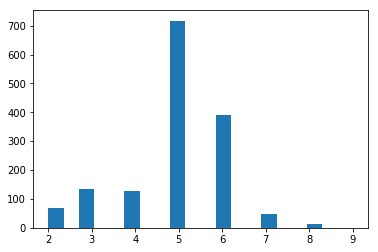

In [19]:
bins, counts = data.select('magnitude').rdd.flatMap(lambda x: x).histogram(20)
plt.hist(bins[:-1], bins=bins, weights=counts)

In [20]:
# drop appropraite row entries from previous exploration and see how many entries were lost, we see there were 19
data = data.filter(data.IPgeo != "Canada")
data = data.filter(data.IPgeo != "United Kingdom")
data = data.filter(data.IPgeo != "Australia")
data = data.filter(data.IPgeo != "Poland")
data = data.filter(data.IPgeo != "Ireland")
data = data.filter(data.IPgeo != "Singapore")
#drop 5010 and 7024 event categories
data = data.filter(data.event_category != 5010)
data = data.filter(data.event_category != 7024)

data.count()


1481

In [22]:
# since we're assuming time agnostic lets randomize the dataframe
r_data = data.orderBy(rand())

In [23]:
# now we string index our categorical columns
str_col = ['protocolName', 'event_category', 'IPgeo', 'deviceId']
label = 'event_category'
stages = []
for c in str_col:
    indexer = StringIndexer(inputCol=c, outputCol=c+'_index')
    stages += [indexer]
pipeline = Pipeline(stages=stages)
model = pipeline.fit(r_data)
transformed = model.transform(r_data)
transformed = transformed.drop('protocolName', 'IPgeo', 'event_category', 'deviceId')
transformed.show()
df = transformed.toPandas()

+---------+-----------+--------+---------+------------------+--------------------+-----------+--------------+
|relevance|credibility|severity|magnitude|protocolName_index|event_category_index|IPgeo_index|deviceId_index|
+---------+-----------+--------+---------+------------------+--------------------+-----------+--------------+
|       10|         10|       0|        6|               0.0|                 0.0|        1.0|           0.0|
|        8|         10|       0|        5|               1.0|                 0.0|        0.0|           0.0|
|       10|         10|       0|        6|               0.0|                 0.0|        1.0|           0.0|
|        8|         10|       0|        5|               1.0|                 0.0|        0.0|           0.0|
|        8|         10|       0|        5|               1.0|                 0.0|        0.0|           0.0|
|        8|         10|       0|        5|               1.0|                 0.0|        0.0|           0.0|
|        3

(array([758.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 692.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  31.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <a list of 20 Patch objects>)

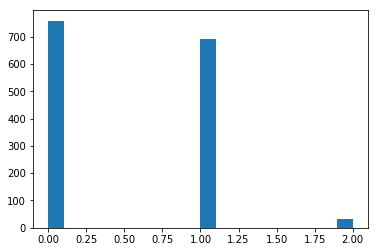

In [25]:
# histograms of the columns we skipped earlier
bins, counts = transformed.select('protocolName_index').rdd.flatMap(lambda x: x).histogram(20)
plt.hist(bins[:-1], bins=bins, weights=counts)

(array([1042.,    0.,    0.,    0.,    0.,    0.,  431.,    0.,    0.,
           0.,    0.,    0.,    0.,    6.,    0.,    0.,    0.,    0.,
           0.,    2.]),
 array([0.  , 0.15, 0.3 , 0.45, 0.6 , 0.75, 0.9 , 1.05, 1.2 , 1.35, 1.5 ,
        1.65, 1.8 , 1.95, 2.1 , 2.25, 2.4 , 2.55, 2.7 , 2.85, 3.  ]),
 <a list of 20 Patch objects>)

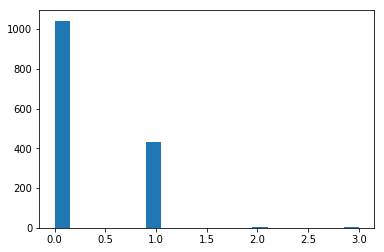

In [26]:
bins, counts = transformed.select('IPgeo_index').rdd.flatMap(lambda x: x).histogram(20)
plt.hist(bins[:-1], bins=bins, weights=counts)

(array([1299.,    0.,    0.,    0.,    0.,  123.,    0.,    0.,    0.,
           0.,   40.,    0.,    0.,    0.,    0.,   11.,    0.,    0.,
           0.,    8.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
        2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. ]),
 <a list of 20 Patch objects>)

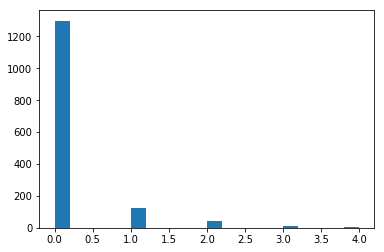

In [28]:
bins, counts = transformed.select('deviceId_index').rdd.flatMap(lambda x: x).histogram(20)
plt.hist(bins[:-1], bins=bins, weights=counts)

(array([1319.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,  135.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,   27.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <a list of 20 Patch objects>)

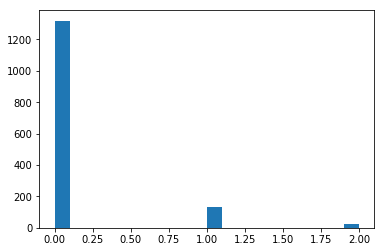

In [29]:
bins, counts = transformed.select('event_category_index').rdd.flatMap(lambda x: x).histogram(20)
plt.hist(bins[:-1], bins=bins, weights=counts)

In [34]:
#not lets do our test train split
train, test = transformed.randomSplit([0.70, 0.30], seed=1234)
x_train = train.drop('event_category_index')
y_train = train.select('event_category_index')
x_test = test.drop('event_category_index')
y_test = test.select('event_category_index')

In [35]:
# manually inspect how many entries of each category exist
#we see we are mssing one category in x_test however there aren't any categories in test that arent in train
traintest_names = x_train.columns
for c in traintest_names:
    x_train.groupby(c).count().show()
    x_test.groupby(c).count().show()


+---------+-----+
|relevance|count|
+---------+-----+
|        1|   22|
|        6|   89|
|        3|   85|
|        5|   36|
|        8|  541|
|       10|  280|
+---------+-----+

+---------+-----+
|relevance|count|
+---------+-----+
|        1|   11|
|        6|   38|
|        3|   43|
|        5|   15|
|        8|  212|
|       10|  109|
+---------+-----+

+-----------+-----+
|credibility|count|
+-----------+-----+
|          5|  185|
|         10|  868|
+-----------+-----+

+-----------+-----+
|credibility|count|
+-----------+-----+
|          5|   82|
|         10|  346|
+-----------+-----+

+--------+-----+
|severity|count|
+--------+-----+
|       6|    3|
|       4|   98|
|       0|  952|
+--------+-----+

+--------+-----+
|severity|count|
+--------+-----+
|       6|    2|
|       4|   59|
|       0|  367|
+--------+-----+

+---------+-----+
|magnitude|count|
+---------+-----+
|        6|  276|
|        3|   94|
|        5|  519|
|        4|   79|
|        8|    5|
|        7| 

In [37]:
#same for target
y_train.groupby('event_category_index').count().show()
y_test.groupby('event_category_index').count().show()

+--------------------+-----+
|event_category_index|count|
+--------------------+-----+
|                 0.0|  952|
|                 1.0|   83|
|                 2.0|   18|
+--------------------+-----+

+--------------------+-----+
|event_category_index|count|
+--------------------+-----+
|                 0.0|  367|
|                 1.0|   52|
|                 2.0|    9|
+--------------------+-----+



In [38]:
# move it all to numpy
x_train_pd = x_train.toPandas()
y_train_pd = y_train.toPandas()
x_test_pd = x_test.toPandas()
y_test_pd = y_test.toPandas()
y_train_np = y_train_pd.as_matrix()
y_test_np = y_test_pd.as_matrix()
x_train_np = x_train_pd.as_matrix()
x_test_np = x_test_pd.as_matrix()

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [39]:
# one hot encode target
from keras.utils import to_categorical
y_train_2 = to_categorical(y_train_np)
y_test_2 = to_categorical(y_test_np)
y_train_2[0:5]

Using TensorFlow backend.


array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [40]:
# build keras model
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
#create model
model = Sequential()

#get number of columns in training data
n_cols = x_train_pd.shape[1]
print(n_cols)
#add model layers
model.add(Dense(250, activation='relu', input_shape=(n_cols,)))
model.add(Dense(250, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#set early stopping monitor so the model stops training when it won't improve anymore
early_stopping_monitor = EarlyStopping(patience=3)
model.summary()
#train model
model.fit(x_train_np, y_train_2, batch_size=64, validation_split=0.2, epochs=30)

7
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 250)               2000      
_________________________________________________________________
dense_2 (Dense)              (None, 250)               62750     
_________________________________________________________________
dense_3 (Dense)              (None, 250)               62750     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 753       
Total params: 128,253
Trainable params: 128,253
Non-trainable params: 0
_________________________________________________________________
Train on 842 samples, validate on 211 samples
Epoch 1/30
842/842 [==============================] - 6s 7ms/step - loss: 0.2494 - acc: 0.9133 - val_loss: 0.1223 - val_acc: 0.9810
Epoch 2/30
842/842 [==============================] - 0s 457us/step - loss: 0.0686 - acc

In [41]:
# look at predictions
test_y_predictions = model.predict(x_test_pd)
print(np.around(test_y_predictions, decimals=1))
#test_y_predictions.around([0:100], decimals=1)


[[0.  0.9 0.1]
 [0.  0.6 0.4]
 [1.  0.  0. ]
 ...
 [1.  0.  0. ]
 [1.  0.  0. ]
 [0.  1.  0. ]]


In [42]:
# decision tree classifier via scikit
dt_df = df
x_cols = ['relevance', 'credibility', 'severity', 'magnitude', 'protocolName_index', 'IPgeo_index', 'deviceId_index']
y_cols = ['event_category_index']
x = dt_df[x_cols]
y = dt_df[y_cols]
x_train_sk, x_test_sk, y_train_sk, y_test_sk = train_test_split(x, y, test_size=0.3, random_state=1)

In [43]:
# decision tree classifier
dtclf = DecisionTreeClassifier()
dtclf = dtclf.fit(x_train_sk, y_train_sk)
y_pred_sk = dtclf.predict(x_test_sk)


In [44]:
#decision tree classifier accuracy
print("Accuracy:",metrics.accuracy_score(y_test_sk, y_pred_sk))

Accuracy: 0.9887640449438202


In [45]:
# Create Decision Tree classifer using entropy measure
dtclf1 = DecisionTreeClassifier(criterion="entropy", max_depth=3)
dtclf1 = dtclf1.fit(x_train_sk,y_train_sk)
y_pred_sk1 = dtclf1.predict(x_test_sk)
# Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_test_sk, y_pred_sk1))

Accuracy: 0.9887640449438202


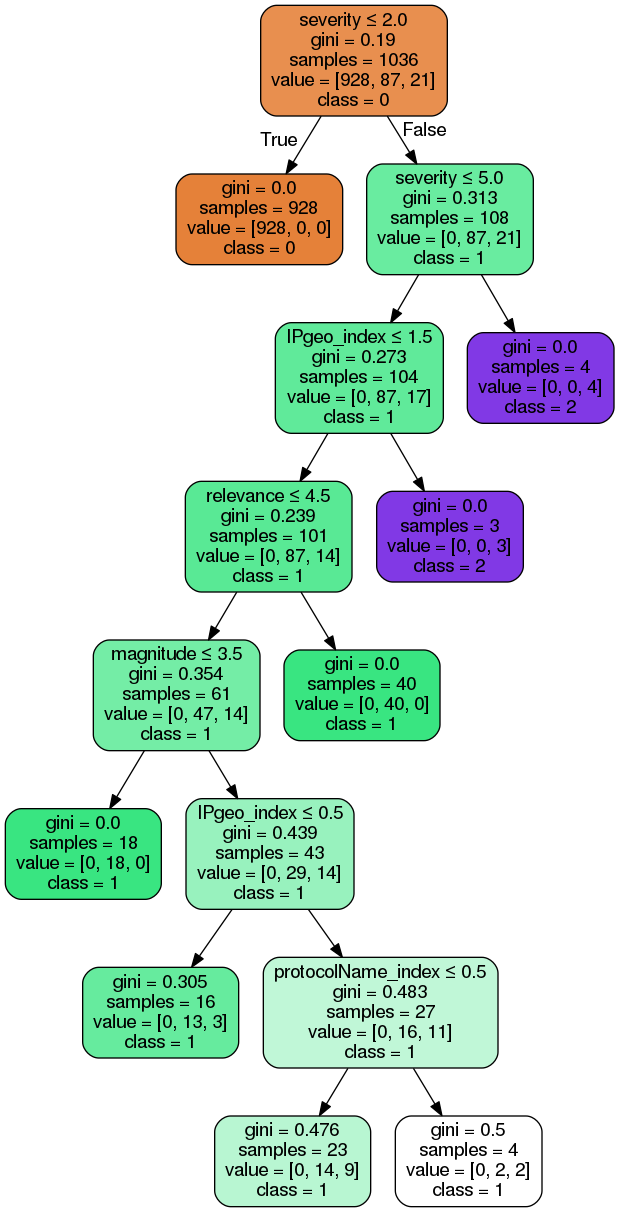

In [46]:
#decision tree classifier graph gini
dot_data = StringIO()
export_graphviz(dtclf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = x_cols,class_names=['0','1','2'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('firewall.png')
Image(graph.create_png())

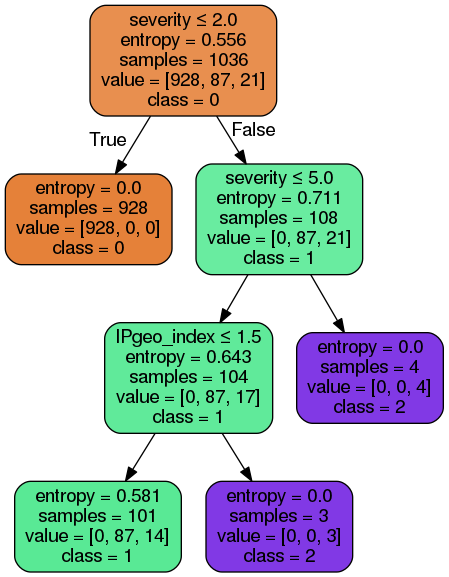

In [47]:
#Decision tree classifier graph entropy
dot_data1 = StringIO()
export_graphviz(dtclf1, out_file=dot_data1,  
                filled=True, rounded=True,
                special_characters=True, feature_names = x_cols,class_names=['0','1','2'])
graph1 = pydotplus.graph_from_dot_data(dot_data1.getvalue())  
graph1.write_png('firewall1.png')
Image(graph1.create_png())